In [1]:
library("ImpulseDE2")
library('dplyr')
library(plyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




In [2]:
server=FALSE
if (server){
    pathSave='/home/khrovatin/timeTrajectoriesNet/data/stages/DE_across_stages/'
    pathCounts='/home/khrovatin/timeTrajectoriesNet/data/counts/'
    pathConditions='/home/khrovatin/timeTrajectoriesNet/data/RPKUM/'
}else{
    pathSave='/home/karin/Documents/timeTrajectories/data/stages/DE_across_stages/'
    pathCounts='/home/karin/Documents/timeTrajectories/data/countsRaw/combined/'
    pathConditions='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
}

In [3]:
genes<-read.table(paste(pathCounts,'mergedGenes_counts.tsv',sep=''), header=TRUE,row.names=1, sep="\t")
conditions<-read.table(paste(pathConditions,'conditions_mergedGenes.tsv',sep=''), header=TRUE,row.names='Measurment', sep="\t")
conditions[conditions=='']=NA
#R imported colnames of genes with changes but gene IDs remained ok
rownames(conditions)<-make.names(rownames(conditions))

In [4]:
#PHENOTYPES_ORDERED=c('no_agg', 'stream', 'lag', 'tag', 'tip', 'slug', 'mhat', 'cul', 'FB', 'yem')
PHENOTYPES_ORDERED=c('no_agg', 'stream', 'lag', 'tag', 'tip', 'slug', 'mhat', 'cul', 'FB')
PHENOTYPES_X=data.frame(Phenotype=PHENOTYPES_ORDERED,X=c(1:length(PHENOTYPES_ORDERED)))

## Main WT stage

In [5]:
Y=conditions[!is.na(conditions[,'main_stage']) & conditions$Group=='WT', 'main_stage',drop=F]
Y[,'Sample']=rownames(Y)
Y[,'Time']=as.numeric(mapvalues(as.character(unlist(Y[,'main_stage'])),from=PHENOTYPES_X$Phenotype,to=PHENOTYPES_X$X))
Y[,'Condition']='case'
Y<-Y[order(Y$Time),]
X=genes[,Y$Sample]

In [6]:
objectImpulseDE2 <- runImpulseDE2(matCountData = as.matrix(X), dfAnnotation = Y,boolCaseCtrl = FALSE,
                                  vecConfounders = NULL,
                                  boolIdentifyTransients = TRUE,scaNProc = 4)

saveRDS(object=objectImpulseDE2,file=paste(pathSave,'DEacrossStages_mainstage_WT.rds',sep=''))
write.table(PHENOTYPES_X,file=paste(pathSave,'DEacrossStages_phenotypesOrder_mainstage_WT.tsv',sep=''),sep='\t',row.names = FALSE)

ImpulseDE2 for count data, v1.8.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5,6,7,8,9
Case: Found the samples at time point 1: FDpool01_TCGCAGG_Hr00_mappedGene_expressions_All_milestone_mRNA_gff,FDpool02_TCGCAGG_Hr00_mappedGene_expressions_All_milestone_mRNA_gff,Ax4_r1_00h_9_S86_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,Ax4_r1_04h_10_S87_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,Ax4_r2_00h_9_S58_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,Ax4_r2_04h_10_S59_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,Pool26_AX4_bio2_hr00_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff,Pool26_AX4_bio2_hr06_7_CTCGATG_mappedGene_expressions_All_milestone_mRNA_gff,pool27_AX4_bio1_hr00_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff,pool27_AX4_bio1_hr06_7_CTCGATG_mappedGene_expressions_All_milestone_mRNA_gff,Pool28_AX4_bio2_hr00_1_13_ACTATCA_mappedGene_expressions_All_milestone_mRNA_gff,pool30_MybBGFP_bio1_hr00_1_TCGCAGG_mapped

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 18 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.75 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 15.13 min.

# Fitting sigmoid model to case condition

Consumed time: 3.93 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 19.88 min.



## All strains

Adjusting for replicates when using all data is incorrect as not all strains have all stages - imbalance between stages. If using only WT batch rep it sometimes gives too many genes that only in WT (and poorly) or missing. When using no batch it sometimes gives FP if one strain has very high samples in a stage.

In [47]:
conditions_annotated=conditions[rowSums(conditions[, PHENOTYPES_ORDERED])>0, ]
# Use only WT data
#conditions_annotated=conditions[rowSums(conditions[, PHENOTYPES_ORDERED])>0 & conditions$Group=='WT', ]
X=data.frame(row.names=rownames(genes))
Y=data.frame()
for (row_idx in 1:dim(conditions_annotated)[1]){
  y=conditions_annotated[row_idx,]
  x=genes[,rownames(y)]
  repeated_sample=0
  for (phenotype in PHENOTYPES_ORDERED){
    if (y[phenotype]==1){
      sample_name=paste(rownames(y),repeated_sample,sep='_')
      X[,sample_name]=x
        #Replicate/strain should not be  used as batch in ImpulseDE2 when using all strains
      Y[sample_name,c('Sample','Condition','Batch','Time')]=c(sample_name,'case',y['Replicate'],PHENOTYPES_X[PHENOTYPES_X['Phenotype']==phenotype,'X'])
      #Only for use in Orange
      #Y[sample_name,c('Measurment','Group','Strain')]=c(rownames(y),y['Group'],y['Strain'])
      repeated_sample=repeated_sample+1
    }
  }
}
Y<-Y[order(Y$Time),]

In [50]:
#For analysis in Orange
#Y_orange=Y[,c('Time','Measurment','Group','Strain')]
#colnames(Y_orange)=c('Stage','Measurment','Group','Strain')
#write.table(Y_orange,file=paste(pathSave,'impulseSamples.tsv',sep=''),sep='\t', col.names=NA)

In [1408]:
#Do not use replicates/strains as confounders as they do not have same stages ('times')
objectImpulseDE2 <- runImpulseDE2(matCountData = as.matrix(X), dfAnnotation = Y,boolCaseCtrl = FALSE,
                                  vecConfounders = c("Batch"),
                                  #vecConfounders = NULL,
                                  boolIdentifyTransients = TRUE,scaNProc = 20)

saveRDS(object=objectImpulseDE2,file=paste(pathSave,'DEacrossStages_WT_noyem_batchrep.rds',sep=''))
write.table(PHENOTYPES_X,file=paste(pathSave,'DEacrossStages_phenotypesOrder_WT_noyem_batchrep.tsv',sep=''),sep='\t',row.names = FALSE)

ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5,6,7,8,9
Case: Found the samples at time point 1: FDpool01_TCGCAGG_Hr00_mappedGene_expressions_All_milestone_mRNA_gff_0,FDpool02_TCGCAGG_Hr00_mappedGene_expressions_All_milestone_mRNA_gff_0,Ax4_r1_00h_9_S86_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,Ax4_r1_04h_10_S87_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,Ax4_r2_00h_9_S58_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,Ax4_r2_04h_10_S59_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,Pool26_AX4_bio2_hr00_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff_0,Pool26_AX4_bio2_hr06_7_CTCGATG_mappedGene_expressions_All_milestone_mRNA_gff_0,pool27_AX4_bio1_hr00_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff_0,pool27_AX4_bio1_hr06_7_CTCGATG_mappedGene_expressions_All_milestone_mRNA_gff_0,Pool28_AX4_bio2_hr00_1_13_ACTATCA_mappedGene_expressions_All_milestone_mRNA_gff_0,pool30_MybBGFP_bio1

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 42 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 1.16 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 17.38 min.

# Fitting sigmoid model to case condition

Consumed time: 5.88 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 24.49 min.



In [12]:
fdr=0.05
result<-objectImpulseDE2$dfImpulseDE2Results
result<-result[result$padj<=fdr & ! is.na(result$padj),]
result<-result[order(result$padj),]
write.table(result,file=paste(pathSave,'DEacrossStages_padj',fdr,'.tsv',sep='') ,sep='\t',row.names = FALSE)

## Individual strains

In [908]:
unique(conditions$Strain)[17:length(unique(conditions$Strain))]

[1] acaA       acaAPkaCoe ac3PkaCoe  PkaCoe     pkaR      
21 Levels: ac3PkaCoe acaA acaAPkaCoe amiB AX4 comH cudA dgcA ecmARm ... tgrC1

In [904]:
for (strain in unique(conditions$Strain)[17:length(unique(conditions$Strain))]){

  conditions_annotated=conditions[rowSums(conditions[, PHENOTYPES_ORDERED])>0 &conditions$Strain==strain, ]
  #Drop phenotypes not annoated in this strain
  phenotypes_count<-colSums(conditions_annotated[, PHENOTYPES_ORDERED])
  phenotypes_present<-names(phenotypes_count[phenotypes_count>0])
  if (length(phenotypes_present)>1){
      phenotypes_x=data.frame(Phenotype=phenotypes_present,X=c(1:length(phenotypes_present)))
      drop<-names(phenotypes_count[phenotypes_count==0])
      drop<-which(colnames(conditions_annotated) %in% drop)
      conditions_annotated=conditions_annotated[,-drop]
      X=data.frame(row.names=rownames(genes))
      Y=data.frame()
      for (row_idx in 1:dim(conditions_annotated)[1]){
        y=conditions_annotated[row_idx,]
        x=genes[,rownames(y)]
        repeated_sample=0
        for (phenotype in phenotypes_present){
          if (y[phenotype]==1){
            sample_name=paste(rownames(y),repeated_sample,sep='_')
            X[,sample_name]=x
            Y[sample_name,c('Sample','Condition','Batch','Time')]=c(sample_name,'case',y['Replicate'],phenotypes_x[phenotypes_x['Phenotype']==phenotype,'X'])
            repeated_sample=repeated_sample+1
          }
        }
      } 

      Y<-Y[order(Y$Time),]
      print(strain)
      print(dim(conditions_annotated))
      print(paste(dim(X)[1],dim(X)[2],sum(conditions_annotated[,phenotypes_present])))
      tryCatch({
          objectImpulseDE2 <- runImpulseDE2(matCountData = as.matrix(X), dfAnnotation = Y,boolCaseCtrl = FALSE,
                                        vecConfounders = c("Batch"), boolIdentifyTransients = TRUE,scaNProc = 20 )
          saveRDS(object=objectImpulseDE2,file=paste(pathSave,'strain/',strain,'_DEacrossStages.rds',sep=''))
          write.table(phenotypes_x,file=paste(pathSave,'strain/',strain,'_DEacrossStages_phenotypesOrder.tsv',sep=''),sep='\t',row.names = FALSE)

      }, error=function(cond) {
          print(paste('Error in strain ',strain,cond))
      }
      )

     }
}
    

[1] "acaA"
[1] "acaA"
[1] 12  7
[1] "12828 13 13"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2
Case: Found the samples at time point 1: pool30_acaA__bio1_hr00_13_ACTATCA_mappedGene_expressions_All_milestone_mRNA_gff_0,pool30_acaA__bio1_hr06_19_GAATCTC_mappedGene_expressions_All_milestone_mRNA_gff_0,pool30_acaA__bio1_hr08_20_CATGCTC_mappedGene_expressions_All_milestone_mRNA_gff_0,pool30_acaA__bio1_hr12_21_ACGCAAC_mappedGene_expressions_All_milestone_mRNA_gff_0,pool30_acaA__bio1_hr16_22_GCATTGG_mappedGene_expressions_All_milestone_mRNA_gff_0,pool30_acaA__bio1_hr20_23_GATCTCG_mappedGene_expressions_All_milestone_mRNA_gff_0,pool30_acaA__bio1_hr24_24_CAATATG_mappedGene_expressions_All_milestone_mRNA_gff_0,Pool29_acaA__bio2_hr00_7_CTCGATG_mappedGene_expressions_All_milestone_mRNA_gff_0,Pool29_acaA__bio2_hr08_14_TTGGATC_mappedGene_expressions_All_milestone_mRNA_gff_0,Pool29_acaA__bio2_hr16_16_TAATGCG_mappedGene_expressions_All_milestone_mRNA_gff_0,Pool29_acaA__bio2_hr20_17_AGGTACC_mappedGene_expressions_All_m

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

Consumed time: 0.05 min.

# Compute size factors

# Fitting null and alternative model to the genes

Timing stopped at: 1.52 1.932 0.826

Timing stopped at: 6.276 3.948 4.953



[1] "Error in strain  acaA Error: BiocParallel errors\n  element index: 1, 2, 3, 4, 5, 6, ...\n  first error: wrong sign in 'by' argument\n"
[1] "mybB"


In [237]:
fdr=0.05
result<-objectImpulseDE2$dfImpulseDE2Results
result<-result[result$padj<=fdr & ! is.na(result$padj),]
result<-result[order(result$padj),]

In [756]:
result<-result[order(result$padj),]

In [757]:
top<-rownames(result[result$isMonotonous,])[1:20]


In [303]:
nrow(result)

[1] 6910

In [276]:
length(rownames(result))

[1] 7428

In [1347]:
colnames(parsed)

[1] "impulse_padj"          "impulseTOsigmoid_padj" "sigmoid_padj"         
 [4] "Type"                  "Direction"             "Assignment"           
 [7] "no_agg"                "stream"                "lag"                  
[10] "tag"                   "tip"                   "slug"                 
[13] "mhat"                  "cul"                   "FB"                   
[16] "yem"

In [1350]:
parsed[order(parsed$impulse_padj),][1:100,]

,impulse_padj,impulseTOsigmoid_padj,sigmoid_padj,Type,Direction,Assignment,no_agg,stream,lag,tag,tip,slug,mhat,cul,FB,yem
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
DDB_G0269574,0.000000e+00,4.263958e-32,0.000000e+00,monotonous,up,impulse_manual_border,down,down,down,down,down,down,down,down,down,up
DDB_G0271850,0.000000e+00,1.063147e-37,3.507861e-307,monotonous,up,impulse_manual_border,down,down,down,down,down,down,down,down,down,up
DDB_G0272570,0.000000e+00,7.490363e-11,0.000000e+00,monotonous,up,impulse_manual_border,down,down,down,down,down,down,down,down,down,up
DDB_G0272835,0.000000e+00,9.372950e-07,0.000000e+00,monotonous,up,impulse_manual_border,down,down,down,down,down,down,down,down,down,up
DDB_G0273225,0.000000e+00,3.511376e-04,0.000000e+00,monotonous,up,impulse_manual_border,down,down,down,down,down,down,down,down,down,up
DDB_G0281091,0.000000e+00,1.003168e-08,0.000000e+00,monotonous,up,impulse_manual_border,down,down,down,down,down,down,down,down,down,up
DDB_G0281895,0.000000e+00,1.397528e-10,0.000000e+00,monotonous,up,impulse,down,down,down,down,up,up,up,up,up,up
DDB_G0284677,0.000000e+00,6.709416e-08,0.000000e+00,monotonous,down,impulse_manual_border,up,up,up,up,up,up,up,up,up,down
DDB_G0286639,0.000000e+00,3.463591e-01,0.000000e+00,monotonous,up,impulse_manual_border,down,down,down,down,down,down,down,down,down,up


In [922]:
library(ggplot2)

In [72]:
gene_ids<-rownames(parsed[parsed$Assignment=='impulse_manual_peak' ,])[1:200]

In [73]:
#gene_ids=c('DDB_G0289979')
lsgplotsGenes <- plotGenes(
vecGeneIDs = gene_ids,
scaNTopIDs = NULL,
objectImpulseDE2 = objectImpulseDE2,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL)

[1] "Setting boolSimplePlot=TRUE as no batch structure was found."


             impulse_padj impulseTOsigmoid_padj sigmoid_padj      Type
DDB_G0272158 1.085716e-31          3.268781e-20 3.766912e-12 transient
                      Assignment no_agg_stream stream_lag lag_tag tag_tip
DDB_G0272158 impulse_manual_peak             0          0       1       0
             tip_slug slug_mhat mhat_cul cul_FB Direction no_agg stream  lag
DDB_G0272158        1         0        0      0        up   down   down down
             tag tip slug mhat  cul   FB
DDB_G0272158  up  up down down down down
[1] "DDB_G0272158"
                     Gene            p         padj loglik_full loglik_red
DDB_G0272158 DDB_G0272158 2.301485e-32 1.085716e-31   -344.5021  -423.6423
             df_full df_red     mean converge_impulse converge_const
DDB_G0272158       7      2 124.4473                0              0
             converge_sigmoid impulseTOsigmoid_p impulseTOsigmoid_padj
DDB_G0272158                0       1.565153e-22          3.268781e-20
             sigmoidTOcon

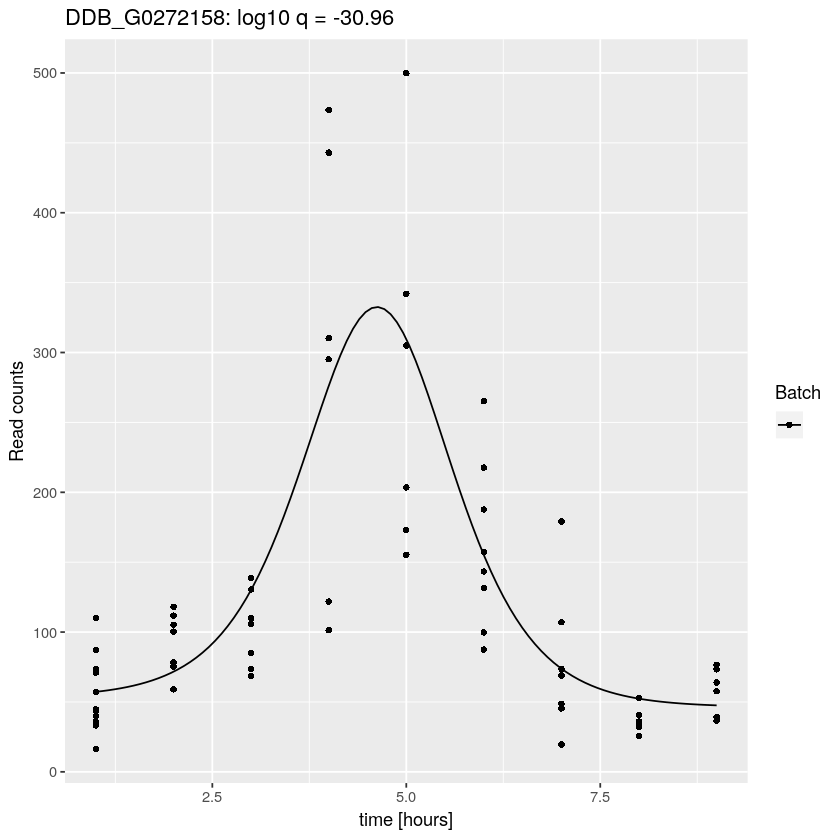

In [81]:
i=40
print(parsed[gene_ids[i],])
print(lsgplotsGenes[[i]])
print(gene_ids[i])
print(objectImpulseDE2$dfImpulseDE2Results[gene_ids[i],])

print(objectImpulseDE2@lsModelFits$case[gene_ids[i]][[1]]$lsImpulseFit$vecImpulseParam)
print(objectImpulseDE2@lsModelFits$case[gene_ids[i]][[1]]$lsSigmoidFit$vecSigmoidParam)

## Parse the results - find neighbouring stages where transition occurs

In [13]:
#For deseq object of all  strains combined
objectImpulseDE2<-readRDS(paste(pathSave,'DEacrossStages_mainstage_WT.rds',sep=''))

phenotypes_x<-read.table(paste(pathSave,'DEacrossStages_phenotypesOrder_mainstage_WT.tsv',sep=''),header=TRUE)
phenotypes_x<-phenotypes_x[order(phenotypes_x$X),]
phenotypes_vec<-as.vector(phenotypes_x[,'Phenotype'])
min_x<-min(phenotypes_x$X)
max_x<-max(phenotypes_x$X)
times_all=sort(phenotypes_x$X)

fdr_thershold=0.001
# Default is 0.001, but they used 0.01 in the paper; 0.001 seems to neglect many probably DE genes
objectImpulseDE2<-updateDEAnalysis(objectImpulseDE2,scaQThresTransients=fdr_thershold)

model<-objectImpulseDE2@lsModelFits$case
result<-objectImpulseDE2$dfImpulseDE2Results
result<-result[! is.na(result$padj),]
result<-result[result$isMonotonous |result$isTransient,]
if (nrow(result[result$isMonotonous & result$isTransient,])>0) stop('Asigned both transient and monotonous')
annotation<-objectImpulseDE2@dfAnnotationProc
print(nrow(result))

parsed<-data.frame()

for(gene in rownames(result)){
    parsed[gene,c('impulse_padj','impulseTOsigmoid_padj','sigmoid_padj')]=result[gene,
                                c('padj','impulseTOsigmoid_padj','sigmoidTOconst_padj')]
    type=''
    # Was gene assigned to be transient or monotonous
    if (result[gene,'isTransient']) type='transient'
    if (result[gene,'isMonotonous']) type='monotonous'
    parsed[gene,'Type']=type
    
    if (type=='monotonous'){
        
        # If monotonous it can be sigmoid or impulse monotonous - if only sigmoid was used the split could be 
        # wrong (in the middle of relatively stable stage) - thus use as threshold the t from impulse 
        # that is closest to the sigmoid t
        if(result[gene,'padj']>result[gene,'sigmoidTOconst_padj']){
            model_data=as.list(model[gene][[1]]$lsSigmoidFit$vecSigmoidParam)
            t=model_data$t
        }else{
            model_data=as.list(model[gene][[1]]$lsSigmoidFit$vecSigmoidParam)
            model_impulse=as.list(model[gene][[1]]$lsImpulseFit$vecImpulseParam)
            diff_t1=abs(model_data$t-model_impulse$t1)
            diff_t2=abs(model_data$t-model_impulse$t2)
            if(diff_t1<diff_t2){t=model_impulse$t1
            } else {t=model_impulse$t2}
        }
        
        # If t in between stages assign impulse, else (t larger/smaller than last/first stage) assume 
        # that only the last/first stage is DE - assign impulse_manual as this is not directly based on the model
        assignment=NA
        if (min_x<t & t<max_x){
            assignment='impulse'
        #Assumes that stages/times are integers
        } else if (min_x>=t ){
            t=min_x+0.1
            assignment='impulse_manual_border'
        } else if (max_x <= t ){
            t=max_x-0.1
            assignment='impulse_manual_border'
        }
        parsed[gene,'Assignment']=assignment

        # Does gene change up or down through time and which stages are on each side of the tipping point
        phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t,'Phenotype'])
        phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t,'Phenotype'])
        transition=paste(tail(phenotypes1, n=1),head(phenotypes2,n=1),sep='_')
        for(idx in 1:(length(phenotypes_vec)-1)){
            neighbouring=paste(phenotypes_vec[idx],phenotypes_vec[idx+1],sep='_')
            if (neighbouring==transition){ 
                parsed[gene,neighbouring]=1
            }else {
                parsed[gene,neighbouring]=0
            }
        }
        if (model_data$h1>model_data$h0) {
            parsed[gene,'Direction']='up'
            parsed[gene,phenotypes1]='down'
            parsed[gene,phenotypes2]='up'
        }else{
            parsed[gene,'Direction']='down'
            parsed[gene,phenotypes1]='up'
            parsed[gene,phenotypes2]='down'
        }
        
    } else if (type=='transient') {
        model_data=as.list(model[gene][[1]]$lsImpulseFit$vecImpulseParam)
        t1=model_data$t1
        t2=model_data$t2
        proceed=TRUE
        # t1,t2 can be between different stages - assign phenotypes to up/down based on t1,t2 and 
        # assignments is based directly on the models ('impulse'). If t1/t2 is larger or smaller 
        # than first/last stage assume that only last/first stage is in this state (assignment is 
        # impulse_manual_border). If t1,t2 are between the same two stages assume there is a peak/vallley - 
        # set t1,t2 so that stages closest to original t1,t2 now represent peak/valley
        # (assignment is impulse_manual_peak). If t1>t2 (except if it was corrected before e.g.
        # in  impulse_manual_peak, which corrects t1,t2) switch t1 and t2 - impulse_manual_swap. 
        # If impulse_manual_peak or impulse_manual_swap find h0,1,2 as averages in stages between 
        # times with data defined by impulse model. Changed h is different from the impulse h - 
        # used only for deteriming up/down expression. This does not account for batches.
        assignment=NA
        #Assumes that stages/times are integers
        if (min_x<t1 & t1<max_x & min_x<t2 & t2<max_x & floor(t1)!=floor(t2)){
            assignment='impulse'
        }
        # Check this before reasigning border so that reasigned border does not cause this situation
        if(floor(t1)==floor(t2)){
            assignment='impulse_manual_peak'
            #Expression predicted by ImpulseDE2
            values=model[gene][[1]]$lsImpulseFit$vecImpulseValue
            values=merge(values,annotation,by="row.names",all.x=TRUE)
            
            #Find single peak/valley near the t1,t2
            ##Mean of each stage group
            #values_mean=aggregate(values$x, by=list(values$Time), FUN=mean)
            ##Peak or valley
            #peak_max=values_mean[values_mean$x==max(values_mean$x),]$Group.1 #Peak (max expression)
            #peak_min=values_mean[values_mean$x==min(values_mean$x),]$Group.1 #Valley (min expression)
            ##Peak (valley) identified in wrong place or correct - is it neighboursing to the wrongly assigned t?
            #if (abs(peak_max-t1)<=1) {
            #    peak=peak_max
            #}else if (abs(peak_min-t1)<=1){
            #    peak=peak_min
            #}else{
            #    print(paste('Peak identified at wrong place for gene ',gene))
            #    proceed=FALSE
            #    assignment=NA
            #}
            #t1=peak-0.1
            #t2=peak+0.1
            
            #Assign t1,t2 so that the two points closest to t1,t2 represent peak/valley, except if
            # t1,t2 thus get below/above min/max times - assign single point as peak/valley
            t1=max(times_all[times_all<t1])-0.1
            t2=min(times_all[times_all>t2])+0.1
            if(min_x>=t1 & t1<max_x){
                t1=min_x+0.1
            }
            if(min_x<t2 & t2>=max_x){
                t2=max_x-0.1
            }

            
            model_data$h0<-mean(values[values$Time<t1,'x'])
            model_data$h1<-mean(values[values$Time>t1 & values$Time<t2,'x'])
            model_data$h2<-mean(values[values$Time>t2,'x'])

        }
        if (t2<t1){
            # Swap t1,t2 - can also reasign border
            t_temp=t1
            t1=t2
            t2=t_temp
            #Reasign border if needed
            if(min_x>=t1 & t1<max_x){
                t1=min_x+0.1
            }
            if(min_x<t2 & t2>=max_x){
                t2=max_x-0.1
            }
            assignment='impulse_manual_swapped'
            # Expression predicted by ImpulseDE2
            values=model[gene][[1]]$lsImpulseFit$vecImpulseValue
            values=merge(values,annotation,by="row.names",all.x=TRUE)
            model_data$h0<-mean(values[values$Time<t1,'x'])
            model_data$h1<-mean(values[values$Time>t1 & values$Time<t2,'x'])
            model_data$h2<-mean(values[values$Time>t2,'x'])

        }
        #This may cause t1&t2 to be equal
        if(min_x>=t1 & t1<max_x){
            if (is.na(assignment)) assignment='impulse_manual_border'
            t1=min_x+0.1
        }
        if(min_x<t2 & t2>=max_x){
            if (is.na(assignment)) assignment='impulse_manual_border'
            t2=max_x-0.1
        }
        # Check again if t1==t2 - the case where this was so originally was already dealt with
        # Treat this as monotonous
        if (floor(t1)==floor(t2)){
            parsed[gene,'Type']='transient_monotonous'
            t2=NA
            # Expression predicted by ImpulseDE2
            values=model[gene][[1]]$lsImpulseFit$vecImpulseValue
            values=merge(values,annotation,by="row.names",all.x=TRUE)
            model_data$h0<-mean(values[values$Time<t1,'x'])
            model_data$h1<-mean(values[values$Time>t1,'x'])
            model_data$h2<-NA
        }
        
        parsed[gene,'Assignment']=assignment
        
        if(proceed & !is.na(assignment)){
        # Where in fact transient after parsing t1,t2
        if(is.na(t2)){
            phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t1,'Phenotype'])
            phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t1,'Phenotype'])
            transition=paste(tail(phenotypes1, n=1),head(phenotypes2,n=1),sep='_')
            for(idx in 1:(length(phenotypes_vec)-1)){
                neighbouring=paste(phenotypes_vec[idx],phenotypes_vec[idx+1],sep='_')
                if (neighbouring==transition){ 
                    parsed[gene,neighbouring]=1
                }else {
                    parsed[gene,neighbouring]=0
                }
            }

            if (model_data$h1>model_data$h0) {
                parsed[gene,'Direction']='up'
                parsed[gene,phenotypes1]='down'
                parsed[gene,phenotypes2]='up'
            }else{
                parsed[gene,'Direction']='down'
                parsed[gene,phenotypes1]='up'
                parsed[gene,phenotypes2]='down'
            }
        # Actual impulse
        } else{
            phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t1 |phenotypes_x$X>t2,'Phenotype'])
            phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t1 & phenotypes_x$X<t2,'Phenotype'])
            transition_stage1=tail(as.vector(phenotypes_x[phenotypes_x$X<t1,'Phenotype']),n=1)
            transition_stage2=head(as.vector(phenotypes_x[phenotypes_x$X>t1,'Phenotype']),n=1)
            transition_stage3=tail(as.vector(phenotypes_x[phenotypes_x$X<t2,'Phenotype']),n=1)
            transition_stage4=head(as.vector(phenotypes_x[phenotypes_x$X>t2,'Phenotype']),n=1)
            transition1=paste(transition_stage1,transition_stage2,sep='_')
            transition2=paste(transition_stage3,transition_stage4,sep='_')
            for(idx in 1:(length(phenotypes_vec)-1)){
                neighbouring=paste(phenotypes_vec[idx],phenotypes_vec[idx+1],sep='_')
                if (neighbouring==transition1 | neighbouring==transition2){ 
                    parsed[gene,neighbouring]=1
                }else {
                    parsed[gene,neighbouring]=0
                }
            }

            if(model_data$h0<model_data$h1 & model_data$h2<model_data$h1){
                parsed[gene,'Direction']='up'
                parsed[gene,phenotypes1]='down'
                parsed[gene,phenotypes2]='up'

            } else if (model_data$h0>model_data$h1 & model_data$h2>model_data$h1) {
                parsed[gene,'Direction']='down'
                parsed[gene,phenotypes1]='up'
                parsed[gene,phenotypes2]='down'

            } else{
               stop(paste('Problem in stage annotation for',gene)) 
            }
            
        }
        }
    }
}
#parsed=parsed[,c(c('impulse_padj','impulseTOsigmoid_padj','sigmoid_padj','Type','Direction','Assignment')
#                 ,as.vector(phenotypes_x$Phenotype))]
parsed2<-parsed[! is.na(parsed$Assignment),]
print(paste(sum(parsed2$Assignment=='impulse'),sum(parsed2$Assignment=='impulse_manual_border'),
            sum(parsed2$Assignment=='impulse_manual_peak'),sum(parsed2$Assignment=='impulse_manual_swapped')))

write.table(parsed,paste(pathSave,'DEacrossStages_summary_mainstage_WT_',fdr_thershold,'.tsv',sep=''),sep='\t',col.names = NA)

[1] 9192
[1] "6781 2130 248 33"


## Parse the result - find stages where gene is up(down)regulated

In [1410]:
#For deseq object of all  strains combined
objectImpulseDE2<-readRDS(paste(pathSave,'DEacrossStages_WT_noyem_batchrep.rds',sep=''))

phenotypes_x<-read.table(paste(pathSave,'DEacrossStages_phenotypesOrder_WT_noyem_batchrep.tsv',sep=''),header=TRUE)
min_x<-min(phenotypes_x$X)
max_x<-max(phenotypes_x$X)
times_all=sort(phenotypes_x$X)

# Default is 0.001, but they used 0.01 in the paper; 0.001 seems to neglect many probably DE genes
# objectImpulseDE2<-updateDEAnalysis(objectImpulseDE2,scaQThresTransients=0.01)

model<-objectImpulseDE2@lsModelFits$case
result<-objectImpulseDE2$dfImpulseDE2Results
result<-result[! is.na(result$padj),]
result<-result[result$isMonotonous |result$isTransient,]
if (nrow(result[result$isMonotonous & result$isTransient,])>0) stop('Asigned both transient and monotonous')
annotation<-objectImpulseDE2@dfAnnotationProc
print(nrow(result))

parsed<-data.frame()

for(gene in rownames(result)){
    parsed[gene,c('impulse_padj','impulseTOsigmoid_padj','sigmoid_padj')]=result[gene,
                                c('padj','impulseTOsigmoid_padj','sigmoidTOconst_padj')]
    type=''
    # Was gene assigned to be transient or monotonous
    if (result[gene,'isTransient']) type='transient'
    if (result[gene,'isMonotonous']) type='monotonous'
    parsed[gene,'Type']=type
    
    if (type=='monotonous'){
        
        # If monotonous it can be sigmoid or impulse monotonous - if only sigmoid was used the split could be 
        # wrong (in the middle of relatively stable stage) - thus use as threshold the t from impulse 
        # that is closest to the sigmoid t
        if(result[gene,'padj']>result[gene,'sigmoidTOconst_padj']){
            model_data=as.list(model[gene][[1]]$lsSigmoidFit$vecSigmoidParam)
            t=model_data$t
        }else{
            model_data=as.list(model[gene][[1]]$lsSigmoidFit$vecSigmoidParam)
            model_impulse=as.list(model[gene][[1]]$lsImpulseFit$vecImpulseParam)
            diff_t1=abs(model_data$t-model_impulse$t1)
            diff_t2=abs(model_data$t-model_impulse$t2)
            if(diff_t1<diff_t2){t=model_impulse$t1
            } else {t=model_impulse$t2}
        }
        
        # If t in between stages assign impulse, else (t larger/smaller than last/first stage) assume 
        # that only the last/first stage is DE - assign impulse_manual as this is not directly based on the model
        assignment=NA
        if (min_x<t & t<max_x){
            assignment='impulse'
        #Assumes that stages/times are integers
        } else if (min_x>=t ){
            t=min_x+0.1
            assignment='impulse_manual_border'
        } else if (max_x <= t ){
            t=max_x-0.1
            assignment='impulse_manual_border'
        }
        parsed[gene,'Assignment']=assignment

        # Does gene change up or down through time and which stages are on each side of the tipping point
        phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t,'Phenotype'])
        phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t,'Phenotype'])
        if (model_data$h1>model_data$h0) {
            parsed[gene,'Direction']='up'
            parsed[gene,phenotypes1]='down'
            parsed[gene,phenotypes2]='up'
        }else{
            parsed[gene,'Direction']='down'
            parsed[gene,phenotypes1]='up'
            parsed[gene,phenotypes2]='down'
        }
        
    } else if (type=='transient') {
        model_data=as.list(model[gene][[1]]$lsImpulseFit$vecImpulseParam)
        t1=model_data$t1
        t2=model_data$t2
        proceed=TRUE
        # t1,t2 can be between different stages - assign phenotypes to up/down based on t1,t2 and 
        # assignments is based directly on the models ('impulse'). If t1/t2 is larger or smaller 
        # than first/last stage assume that only last/first stage is in this state (assignment is 
        # impulse_manual_border). If t1,t2 are between the same two stages assume there is a peak/vallley - 
        # set t1,t2 so that stages closest to original t1,t2 now represent peak/valley
        # (assignment is impulse_manual_peak). If t1>t2 (except if it was corrected before e.g.
        # in  impulse_manual_peak, which corrects t1,t2) switch t1 and t2 - impulse_manual_swap. 
        # If impulse_manual_peak or impulse_manual_swap find h0,1,2 as averages in stages between 
        # times with data defined by impulse model. Changed h is different from the impulse h - 
        # used only for deteriming up/down expression. This does not account for batches.
        assignment=NA
        #Assumes that stages/times are integers
        if (min_x<t1 & t1<max_x & min_x<t2 & t2<max_x & floor(t1)!=floor(t2)){
            assignment='impulse'
        }
        # Check this before reasigning border so that reasigned border does not cause this situation
        if(floor(t1)==floor(t2)){
            assignment='impulse_manual_peak'
            #Expression predicted by ImpulseDE2
            values=model[gene][[1]]$lsImpulseFit$vecImpulseValue
            values=merge(values,annotation,by="row.names",all.x=TRUE)
            
            #Find single peak/valley near the t1,t2
            ##Mean of each stage group
            #values_mean=aggregate(values$x, by=list(values$Time), FUN=mean)
            ##Peak or valley
            #peak_max=values_mean[values_mean$x==max(values_mean$x),]$Group.1 #Peak (max expression)
            #peak_min=values_mean[values_mean$x==min(values_mean$x),]$Group.1 #Valley (min expression)
            ##Peak (valley) identified in wrong place or correct - is it neighboursing to the wrongly assigned t?
            #if (abs(peak_max-t1)<=1) {
            #    peak=peak_max
            #}else if (abs(peak_min-t1)<=1){
            #    peak=peak_min
            #}else{
            #    print(paste('Peak identified at wrong place for gene ',gene))
            #    proceed=FALSE
            #    assignment=NA
            #}
            #t1=peak-0.1
            #t2=peak+0.1
            
            #Assign t1,t2 so that the two points closest to t1,t2 represent peak/valley, except if
            # t1,t2 thus get below/above min/max times - assign single point as peak/valley
            t1=max(times_all[times_all<t1])-0.1
            t2=min(times_all[times_all>t2])+0.1
            if(min_x>=t1 & t1<max_x){
                t1=min_x+0.1
            }
            if(min_x<t2 & t2>=max_x){
                t2=max_x-0.1
            }

            
            model_data$h0<-mean(values[values$Time<t1,'x'])
            model_data$h1<-mean(values[values$Time>t1 & values$Time<t2,'x'])
            model_data$h2<-mean(values[values$Time>t2,'x'])

        }
        if (t2<t1){
            # Swap t1,t2 - can also reasign border
            t_temp=t1
            t1=t2
            t2=t_temp
            #Reasign border if needed
            if(min_x>=t1 & t1<max_x){
                t1=min_x+0.1
            }
            if(min_x<t2 & t2>=max_x){
                t2=max_x-0.1
            }
            assignment='impulse_manual_swapped'
            # Expression predicted by ImpulseDE2
            values=model[gene][[1]]$lsImpulseFit$vecImpulseValue
            values=merge(values,annotation,by="row.names",all.x=TRUE)
            model_data$h0<-mean(values[values$Time<t1,'x'])
            model_data$h1<-mean(values[values$Time>t1 & values$Time<t2,'x'])
            model_data$h2<-mean(values[values$Time>t2,'x'])

        }
        #This may cause t1&t2 to be equal
        if(min_x>=t1 & t1<max_x){
            if (is.na(assignment)) assignment='impulse_manual_border'
            t1=min_x+0.1
        }
        if(min_x<t2 & t2>=max_x){
            if (is.na(assignment)) assignment='impulse_manual_border'
            t2=max_x-0.1
        }
        # Check again if t1==t2 - the case where this was so originally was already dealt with
        # Treat this as monotonous
        if (floor(t1)==floor(t2)){
            parsed[gene,'Type']='transient_monotonous'
            t2=NA
            # Expression predicted by ImpulseDE2
            values=model[gene][[1]]$lsImpulseFit$vecImpulseValue
            values=merge(values,annotation,by="row.names",all.x=TRUE)
            model_data$h0<-mean(values[values$Time<t1,'x'])
            model_data$h1<-mean(values[values$Time>t1,'x'])
            model_data$h2<-NA
        }
        
        parsed[gene,'Assignment']=assignment
        
        if(proceed & !is.na(assignment)){
        # Where in fact transient after parsing t1,t2
        if(is.na(t2)){
            phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t1,'Phenotype'])
            phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t1,'Phenotype'])

            if (model_data$h1>model_data$h0) {
                parsed[gene,'Direction']='up'
                parsed[gene,phenotypes1]='down'
                parsed[gene,phenotypes2]='up'
            }else{
                parsed[gene,'Direction']='down'
                parsed[gene,phenotypes1]='up'
                parsed[gene,phenotypes2]='down'
            }
        # Actual impulse
        } else{
            phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t1 |phenotypes_x$X>t2,'Phenotype'])
            phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t1 & phenotypes_x$X<t2,'Phenotype'])
            if(model_data$h0<model_data$h1 & model_data$h2<model_data$h1){
                parsed[gene,'Direction']='up'
                parsed[gene,phenotypes1]='down'
                parsed[gene,phenotypes2]='up'

            } else if (model_data$h0>model_data$h1 & model_data$h2>model_data$h1) {
                parsed[gene,'Direction']='down'
                parsed[gene,phenotypes1]='up'
                parsed[gene,phenotypes2]='down'

            } else{
               stop(paste('Problem in stage annotation for',gene)) 
            }
            
        }
        }
    }

}
parsed=parsed[,c(c('impulse_padj','impulseTOsigmoid_padj','sigmoid_padj','Type','Direction','Assignment')
                 ,as.vector(phenotypes_x$Phenotype))]
parsed2<-parsed[! is.na(parsed$Assignment),]
print(paste(sum(parsed2$Assignment=='impulse'),sum(parsed2$Assignment=='impulse_manual_border'),
            sum(parsed2$Assignment=='impulse_manual_peak'),sum(parsed2$Assignment=='impulse_manual_swapped')))

write.table(parsed,paste(pathSave,'DEacrossStages_summary_WT_noyem_batchrep.tsv',sep=''),sep='\t',col.names = NA)

[1] 10485
[1] "7236 2869 327 53"


In [1273]:
#TODO!!!!!!!!!!!!!!!!!!!!!!!!
#Update with the all strains above!!!!



#For deseq objects of individual strains
strain='AX4' 
#for (strain in unique(conditions$Strain)){
if (file.exists(paste(pathSave,'strain/',strain,'_DEacrossStages.rds',sep=''))){

objectImpulseDE2<-readRDS(paste(pathSave,'strain/',strain,'_DEacrossStages.rds',sep=''))
phenotypes_x<-read.table(paste(pathSave,'strain/',strain,'_DEacrossStages_phenotypesOrder.tsv',sep=''),header=TRUE)
min_x<-min(phenotypes_x$X)
max_x<-max(phenotypes_x$X)
times_all=sort(phenotypes_x$X)

#Default is 0.001, but they used 0.01 in the paper, but 0.001 seems to neglect many probably DE genes
objectImpulseDE2<-updateDEAnalysis(objectImpulseDE2,scaQThresTransients=0.01)

model<-objectImpulseDE2@lsModelFits$case
result<-objectImpulseDE2$dfImpulseDE2Results
result<-result[! is.na(result$padj),]
result<-result[result$isMonotonous |result$isTransient,]
if (nrow(result[result$isMonotonous & result$isTransient,])>0) stop('Asigned both transient and monotonous')
annotation<-objectImpulseDE2@dfAnnotationProc
print(paste(strain,nrow(result)))

parsed<-data.frame()

for(gene in rownames(result)){
    parsed[gene,c('impulse_padj','impulseTOsigmoid_padj','sigmoid_padj')]=result[gene,
                                c('padj','impulseTOsigmoid_padj','sigmoidTOconst_padj')]
    type=''
    # Was gene assigned to be transient or monotonous
    if (result[gene,'isTransient']) type='transient'
    if (result[gene,'isMonotonous']) type='monotonous'
    parsed[gene,'Type']=type
    
    if (type=='monotonous'){
        
        # If monotonous it can be sigmoid or impulse monotonous - if only sigmoid was used the split could be 
        # wrong (in the middle of relatively stable stage) - thus use as threshold the t from impulse 
        # that is closest to the sigmoid t
        if(result[gene,'padj']>result[gene,'sigmoidTOconst_padj']){
            model_data=as.list(model[gene][[1]]$lsSigmoidFit$vecSigmoidParam)
            t=model_data$t
        }else{
            model_data=as.list(model[gene][[1]]$lsSigmoidFit$vecSigmoidParam)
            model_impulse=as.list(model[gene][[1]]$lsImpulseFit$vecImpulseParam)
            diff_t1=abs(model_data$t-model_impulse$t1)
            diff_t2=abs(model_data$t-model_impulse$t2)
            if(diff_t1<diff_t2){t=model_impulse$t1
            } else {t=model_impulse$t2}
        }
        
        # If t in between stages assign impulse, else (t larger/smaller than last/first stage) assume 
        # that only the last/first stage is DE - assign impulse_manual as this is not directly based on the model
        assignment=NA
        if (min_x<t & t<max_x){
            assignment='impulse'
        #Assumes that stages/times are integers
        } else if (min_x>=t ){
            t=min_x+0.1
            assignment='impulse_manual_border'
        } else if (max_x <= t ){
            t=max_x-0.1
            assignment='impulse_manual_border'
        }
        parsed[gene,'Assignment']=assignment

        # Does gene change up or down through time and which stages are on each side of the tipping point
        phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t,'Phenotype'])
        phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t,'Phenotype'])
        if (model_data$h1>model_data$h0) {
            parsed[gene,'Direction']='up'
            parsed[gene,phenotypes1]='down'
            parsed[gene,phenotypes2]='up'
        }else{
            parsed[gene,'Direction']='down'
            parsed[gene,phenotypes1]='up'
            parsed[gene,phenotypes2]='down'
        }
        
    } else if (type=='transient') {
        model_data=as.list(model[gene][[1]]$lsImpulseFit$vecImpulseParam)
        t1=model_data$t1
        t2=model_data$t2
        proceed=TRUE
        # t1,t2 can be between different stages - assign phenotypes to up/down based on t1,t2 and 
        # assignments is based directly on the models ('impulse'). If t1/t2 is larger or smaller 
        # than first/last stage assume that only last/first stage is in this state (assignment is 
        # impulse_manual_border). If t1,t2 are between the same two stages assume there is a peak/vallley - 
        # set t1,t2 so that stages closest to original t1,t2 now represent peak/valley
        # (assignment is impulse_manual_peak). If t1>t2 (except if it was corrected before e.g.
        # in  impulse_manual_peak, which corrects t1,t2) switch t1 and t2 - impulse_manual_swap. 
        # If impulse_manual_peak or impulse_manual_swap find h0,1,2 as averages in stages between 
        # times with data defined by impulse model. Changed h is different from the impulse h - 
        # used only for deteriming up/down expression. This does not account for batches.
        assignment=NA
        #Assumes that stages/times are integers
        if (min_x<t1 & t1<max_x & min_x<t2 & t2<max_x & floor(t1)!=floor(t2)){
            assignment='impulse'
        }
        # Check this before reasigning border so that reasigned border does not cause this situation
        if(floor(t1)==floor(t2)){
            assignment='impulse_manual_peak'
            #Expression predicted by ImpulseDE2
            values=model[gene][[1]]$lsImpulseFit$vecImpulseValue
            values=merge(values,annotation,by="row.names",all.x=TRUE)
            
            #Find single peak/valley near the t1,t2
            ##Mean of each stage group
            #values_mean=aggregate(values$x, by=list(values$Time), FUN=mean)
            ##Peak or valley
            #peak_max=values_mean[values_mean$x==max(values_mean$x),]$Group.1 #Peak (max expression)
            #peak_min=values_mean[values_mean$x==min(values_mean$x),]$Group.1 #Valley (min expression)
            ##Peak (valley) identified in wrong place or correct - is it neighboursing to the wrongly assigned t?
            #if (abs(peak_max-t1)<=1) {
            #    peak=peak_max
            #}else if (abs(peak_min-t1)<=1){
            #    peak=peak_min
            #}else{
            #    print(paste('Peak identified at wrong place for gene ',gene))
            #    proceed=FALSE
            #    assignment=NA
            #}
            #t1=peak-0.1
            #t2=peak+0.1
            
            #Assign t1,t2 so that the two points closest to t1,t2 represent peak/valley, except if
            # t1,t2 thus get below/above min/max times - assign single point as peak/valley
            t1=max(times_all[times_all<t1])-0.1
            t2=min(times_all[times_all>t2])+0.1
            if(min_x>=t1 & t1<max_x){
                t1=min_x+0.1
            }
            if(min_x<t2 & t2>=max_x){
                t2=max_x-0.1
            }

            
            model_data$h0<-mean(values[values$Time<t1,'x'])
            model_data$h1<-mean(values[values$Time>t1 & values$Time<t2,'x'])
            model_data$h2<-mean(values[values$Time>t2,'x'])

        }
        if (t2<t1){
            # Swap t1,t2 - can also reasign border
            t_temp=t1
            t1=t2
            t2=t_temp
            #Reasign border if needed
            if(min_x>=t1 & t1<max_x){
                t1=min_x+0.1
            }
            if(min_x<t2 & t2>=max_x){
                t2=max_x-0.1
            }
            assignment='impulse_manual_swapped'
            # Expression predicted by ImpulseDE2
            values=model[gene][[1]]$lsImpulseFit$vecImpulseValue
            values=merge(values,annotation,by="row.names",all.x=TRUE)
            model_data$h0<-mean(values[values$Time<t1,'x'])
            model_data$h1<-mean(values[values$Time>t1 & values$Time<t2,'x'])
            model_data$h2<-mean(values[values$Time>t2,'x'])

        }
        #This may cause t1&t2 to be equal
        if(min_x>=t1 & t1<max_x){
            if (is.na(assignment)) assignment='impulse_manual_border'
            t1=min_x+0.1
        }
        if(min_x<t2 & t2>=max_x){
            if (is.na(assignment)) assignment='impulse_manual_border'
            t2=max_x-0.1
        }
        # Check again if t1==t2 - the case where this was so originally was already dealt with
        # Treat this as monotonous
        if (floor(t1)==floor(t2)){
            parsed[gene,'Type']='transient_monotonous'
            t2=NA
            # Expression predicted by ImpulseDE2
            values=model[gene][[1]]$lsImpulseFit$vecImpulseValue
            values=merge(values,annotation,by="row.names",all.x=TRUE)
            model_data$h0<-mean(values[values$Time<t1,'x'])
            model_data$h1<-mean(values[values$Time>t1,'x'])
            model_data$h2<-NA
        }
        
        parsed[gene,'Assignment']=assignment
        
        if(proceed & !is.na(assignment)){
        # Where in fact transient after parsing t1,t2
        if(is.na(t2)){
            phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t1,'Phenotype'])
            phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t1,'Phenotype'])

            if (model_data$h1>model_data$h0) {
                parsed[gene,'Direction']='up'
                parsed[gene,phenotypes1]='down'
                parsed[gene,phenotypes2]='up'
            }else{
                parsed[gene,'Direction']='down'
                parsed[gene,phenotypes1]='up'
                parsed[gene,phenotypes2]='down'
            }
        # Actual impulse
        } else{
            phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t1 |phenotypes_x$X>t2,'Phenotype'])
            phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t1 & phenotypes_x$X<t2,'Phenotype'])
            if(model_data$h0<model_data$h1 & model_data$h2<model_data$h1){
                parsed[gene,'Direction']='up'
                parsed[gene,phenotypes1]='down'
                parsed[gene,phenotypes2]='up'

            } else if (model_data$h0>model_data$h1 & model_data$h2>model_data$h1) {
                parsed[gene,'Direction']='down'
                parsed[gene,phenotypes1]='up'
                parsed[gene,phenotypes2]='down'

            } else{
               stop(paste('Problem in stage annotation for',gene)) 
            }
            
        }
        }
    }

}
parsed=parsed[,c(c('impulse_padj','impulseTOsigmoid_padj','sigmoid_padj','Type','Direction','Assignment')
                 ,as.vector(phenotypes_x$Phenotype))]
parsed2<-parsed[! is.na(parsed$Assignment),]
print(paste(sum(parsed2$Assignment=='impulse'),sum(parsed2$Assignment=='impulse_manual_border'),
            sum(parsed2$Assignment=='impulse_manual_peak'),sum(parsed2$Assignment=='impulse_manual_swapped')))
#write.table(parsed,paste(pathSave,'strain/',strain,'_DEacrossStages_summary.tsv',sep=''),sep='\t',col.names = NA)
}
#}

[1] "AX4 10708"
[1] "7189 3010 446 63"


In [1265]:
gene_ids<-rownames(parsed[parsed$Assignment=='impulse' & parsed$Type=='transient',])

In [1274]:
parsed['DDB_G0269770',]

,impulse_padj,impulseTOsigmoid_padj,sigmoid_padj,Type,Direction,Assignment,no_agg,stream,lag,tag,tip,slug,mhat,cul,FB
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
DDB_G0269770,1.533452e-05,5.549121e-06,0.5627776,transient,up,impulse_manual_peak,down,up,down,down,down,down,down,down,down


## Genes related with development in AX4

In [877]:
objectImpulseDE2<-readRDS(paste(pathSave,'strain/','AX4','_DEacrossStages.rds',sep=''))

In [878]:
result<-objectImpulseDE2$dfImpulseDE2Results
result<-result[! is.na(result$padj),]
result<-result[order(result$padj),]

Select 2000 genes with lowest Impulse padj in AX4 to use in dimensionality reduction techniques.

In [872]:
top<-data.frame(Gene=rownames(result[1:2000,]))

In [876]:
write.table(top,paste(pathSave,'strain/AX4_bestImpulse2000.tsv',sep=''),sep='\t',row.names = FALSE)

Select all variable (impulse, sigmoid) genes.

In [886]:
top<-data.frame(Gene=rownames(result[result$isMonotonous |result$isTransient,]))
print(dim(top))

[1] 10121     1


In [887]:
write.table(top,paste(pathSave,'strain/AX4_variableImpulseSigmoid.tsv',sep=''),sep='\t',row.names = FALSE)